Rayleigh Taylor instability
======

This example builds a model of the classic Rayleigh Taylor instability. See [here](https://en.wikipedia.org/wiki/Rayleigh%E2%80%93Taylor_instability) for more details on the RT instability. To benchmark the underworld code this notebook also provides a direct comparison to the isoviscous thermochemical convection benchmark values from van Keken *et al.* (1997). The system of equations is given by

$$
    \nabla \cdot \left( \eta \nabla \dot\varepsilon \right) - \nabla p = 
    \left( Ra _T T + Ra _\Gamma \Gamma \right) \mathbf{\hat z}
$$

$$
    \nabla \cdot \mathbf{v} = 0
$$

The thermal and compositional evolution is controlled by advection and (thermal) diffusion

$$
    \frac{D T}{D t} = \nabla^2 T 
$$    

$$
    \frac{D \Gamma}{D t} = 0
$$

Thermal and compositional Rayleigh numbers are defined by

$$ 
    Ra _T = \frac{g \rho \alpha \Delta T h ^3}{\kappa \eta _r} ; \;\;\;\; 
    Ra _\Gamma = \frac{g \Delta \rho _\Gamma h ^3}{\kappa \eta _r}
$$



**Lesson concepts:**
1. More on particle swarms.
2. Producing snapshot images to file (which can then be made into a movie).
3. Comparison of benchmark values.

**Keywords:** particle swarms, Stokes system, advective diffusive systems

**References**

1. van Keken, P.E., S.D. King, H. Schmeling, U.R. Christensen, D.Neumeister and M.-P. Doin. A comparison of methods for the modeling of thermochemical convection. Journal of Geophysical Research, 102, 22,477-22,495, 1997.  
http://onlinelibrary.wiley.com/doi/10.1029/97JB01353/abstract


In [1]:

import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

Setup parameters
-----

Set simulation parameters. The box length is chosen for direct comparison to the benchmark values.

In [2]:
res = 64
boxLength = 0.9142
boxHeight = 1.0

Here we also set the viscosity of the light material ($\eta \leq$ 1) relative to the reference heavy material ($\eta_r = 1$) which is used when we set up the parameters and functions below. This is set to be $\eta =$ 1, 0.1 and 0.01 for the 3 cases given in van Keken *et al.* 1997.

In [3]:
eta = 1.0

**Input/output paths**

Set input and output file directory paths. Input files are previous $v_{rms}$ and $Nu$ numbers as a function of time. The output path directory will contain the resulting $v_{rms}$ and $Nu$ data as well as the image snap shots.

In [4]:
inputPath  = 'RTInput/'
outputPath = 'RTOutput/'
# Make output directory if necessary
import os
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

Create mesh and finite element variables
------

In [5]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

# Create a particle swarm
------

Swarms refer to (large) groups of particles which can advect with the fluid flow. These can be used to determine 'materials' as they can carry local information such as the fluid density and viscosity.

**Setup a swarm**

To set up a swarm of particles the following steps are needed:
1. Initialise a swarm.
2. Define data variable to store an index that will state what material a given particle is.
3. Populate the swarm over the whole domain using the layout command.

In [6]:
# Initialise a swarm.
swarm = uw.swarm.Swarm( mesh=mesh )

# Add a data variable which will store an index to determine material.
materialVariable = swarm.add_variable( dataType="int", count=1 )
vectorVariable = swarm.add_variable( dataType="double", count=2 )

# Create a layout object that will populate the swarm across the whole domain.
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )

# Populate.
swarm.populate_using_layout( layout=swarmLayout )

**Allocate each particle a material index**

Each particle in the swarm can be given individual values, such as viscosity and density. The concept of materials is used in underworld to create groups of particles which have similar behaviour.

The example below sets particles of the swarm to be one of two materials based on the initial particle position in the system. It distinguishes between the positions using the condition 
\\[
0.2 + \cos \left( \frac{2 \pi x}{\lambda} \right) > z
\\]
to have the light material index. Here the notation is adopted of $z$ for coordinate[1], $x$ for coordinate[0] and $\lambda$ for the wavelength. If this condition is not satisfied then the particle will be labelled by the heavy index, as this final condition is always true. For further details, please refer to the user guide and/or docstrings.

Later these materials are given specific densities and viscosities.

In [7]:
# Initialise the 'materialVariable' data to represent two different materials. 
denseIndex = 0
lightIndex = 1

# The form of this perturbation is taken from van Keken et al. 1997
wavelength = 2.0*boxLength
amplitude  = 0.02
offset     = 0.2
k = 2. * math.pi / wavelength

# The particle coordinates will be the input to the function evaluate (see final line in this cell).
# We get proxy for this now using the input() function.
coordinate = fn.input()

# Define our perturbation function. Note that it is a function of the x coordinate, 
# accessed by 'coordinate[0]'.
perturbationFn = offset + amplitude*fn.math.cos( k*coordinate[0] )

# Setup the conditions list for the following conditional function. Where the
# z coordinate (coordinate[1]) is less than the perturbation, set to lightIndex.
conditions = [ ( perturbationFn > coordinate[1] , lightIndex ),
               (                           True , denseIndex ) ]

# The actual function evaluation. Here the conditional function is evaluated at the location
# of each swarm particle. The results are then written to the materialVariable swarm variable.
materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

**Plot the particles by material**

Setup a standard method for plotting all particles in a swarm with colour set by the material index (light or heavy).

In [8]:
picswarm = uw.swarm.PICIntegrationSwarm(swarm)
picswarm.repopulate()

picswarm.particleLocalCount

81896


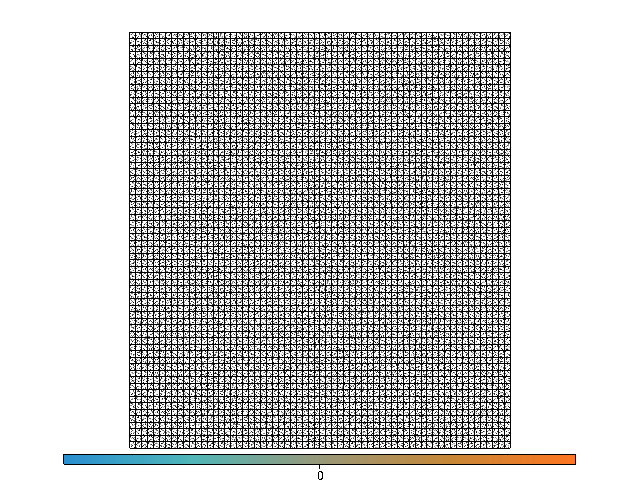

In [9]:
fig = glucifer.Figure()
fig.append(glucifer.objects.Points(swarm))
fig.append(glucifer.objects.Mesh(mesh))
fig.show()

In [10]:


with mesh.deform_mesh():
    mesh.data[0] = [-0.03,-0.03]
# swarm.particleCoordinates.data[:] = fn.input().evaluate(picswarm)

In [11]:
fn.input().evaluate(picswarm)#swarm.particleCoordinates.data[:]

array([[ 0.01339821,  0.01466435],
       [ 0.22775642,  0.74913194],
       [ 0.68485642,  0.24913194],
       ..., 
       [ 0.0966576 ,  0.565625  ],
       [ 0.5537576 ,  0.065625  ],
       [ 0.3823451 ,  0.628125  ]])